In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from copy import deepcopy
from src.tabpfn.model.causalFM import PerFeatureTransformerCATE
from DATA_standard.causaldatasettest import create_test_data_loader
from causalpfn import CATEEstimator
from econml.metalearners import SLearner
from dotenv import load_dotenv
from tabpfn_client import TabPFNRegressor
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
@torch.no_grad()
def eval_one_csv(causalFM, device, csv_path, batch_size=1):
    """
    Evaluate on a single dataset.
    - Uses 70% as the training data and 30% as the test data for one dataset.
    """
    name = os.path.splitext(os.path.basename(csv_path))[0]
    loader = create_test_data_loader(csv_path, batch_size=batch_size, shuffle=False)

    se_list_FM = []
    se_list_PFN = []
    se_list_SL = []
    nsamples = 0

    for batch in loader: # one batch is one CSV file (load all the samples)
        x = batch['X'].to(device)
        a = batch['a'].to(device)
        y = batch['y'].to(device)
        ite = batch['ite'].to(device)  # ground-truth ITE

        # train test split
        ratio = 0.7
        train_text_split = int(y.shape[0] * ratio)

        # Split data into train and test
        x_train = deepcopy(x[:train_text_split].squeeze(1))
        a_train = deepcopy(a[:train_text_split].squeeze(1))
        y_train = deepcopy(y[:train_text_split].squeeze(1))

        x_test = deepcopy(x[train_text_split:].squeeze(1))
        ite_test = deepcopy(ite[train_text_split:].squeeze())

        # print(f"Train samples: {train_text_split}, Test samples: {ite_test.shape[0]}")
        # print("ite_test.shape:", ite_test.shape)

        # Get causalFM predictions using estimate_cate method
        out = causalFM.estimate_cate(x_train, a_train, y_train, x_test)
        cate_test = out['cate']
        # Calculate error
        se = (cate_test - ite_test) ** 2
        se_list_FM.append(se.cpu().numpy())
        nsamples += cate_test.numel()

        x_train = deepcopy(x[:train_text_split].squeeze(1)).cpu().numpy()
        a_train = deepcopy(a[:train_text_split].squeeze(1)).cpu().numpy()[:, 0]
        y_train = deepcopy(y[:train_text_split].squeeze(1)).cpu().numpy()[:, 0]

        x_test = deepcopy(x[train_text_split:].squeeze(1)).cpu().numpy()
        ite_test = deepcopy(ite[train_text_split:].squeeze()).cpu().numpy()
        causalpfn_cate = CATEEstimator(
            device=device,
            verbose=True,
        )
        causalpfn_cate.fit(x_train, a_train, y_train)
        cate_hat = causalpfn_cate.estimate_cate(x_test)
        se = (cate_hat - ite_test) ** 2
        se_list_PFN.append(se)

        tabPFNSLearner = SLearner(overall_model=TabPFNRegressor())
        tabPFNSLearner.fit(y_train, a_train, X=x_train)
        cate = tabPFNSLearner.effect(x_test)
        se = (cate - ite_test) ** 2
        se_list_SL.append(se)

    if nsamples == 0:
        return {'dataset': name, 'samples': 0, 'mse': np.nan, 'pehe': np.nan}

    se_all_FM = np.concatenate(se_list_FM)
    mse_FM = float(np.mean(se_all_FM))
    pehe_FM = float(np.sqrt(mse_FM))

    se_all_PFN = np.concatenate(se_list_PFN)
    mse_PFN = float(np.mean(se_all_PFN))
    pehe_PFN = float(np.sqrt(mse_PFN))

    se_list_SL = np.concatenate(se_list_SL)
    mse_SL = float(np.mean(se_list_SL))
    pehe_SL = float(np.sqrt(mse_SL))

    return [
        {'model': 'CausalFM', 'dataset': name, 'mse': mse_FM, 'pehe': pehe_FM},
        {'model': 'CausalPFN', 'dataset': name, 'mse': mse_PFN, 'pehe': pehe_PFN},
        {'model': 'TabPFN-SL', 'dataset': name, 'mse': mse_SL, 'pehe': pehe_SL}
    ]


In [4]:
data_dir = "benchmark/data/"
data_prefix = "cate_test_dataset"
num_datasets = 11
causal_fm_model_path = 'artifacts/causalfm.pth'
batch_size = 1
gpu = 0
output_dir = 'test_results1'

# Create output directory
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Device
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() and gpu >= 0 else 'cpu')
# print(f"Using device: {device}")

# Model
causalFM = PerFeatureTransformerCATE().to(device)
if not os.path.exists(causal_fm_model_path):
    raise FileNotFoundError(f"Model checkpoint not found: {causal_fm_model_path}")

ckpt = torch.load(causal_fm_model_path, map_location=device)
state = ckpt['model_state_dict'] if 'model_state_dict' in ckpt else ckpt
causalFM.load_state_dict(state)
causalFM.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [6]:
# Evaluate each dataset one by one
rows = []
print("\n=== Per-dataset Test PEHE ===")
for i in tqdm(range(1, num_datasets + 1), desc="Datasets"):
    csv_path = os.path.join(data_dir, f"{data_prefix}_{i}.csv")
    if not os.path.exists(csv_path):
        print(f"[Skip] Not found: {csv_path}")
        continue
    res = eval_one_csv(causalFM, device, csv_path, batch_size=batch_size)
    rows += res
    # Directly print the result for this CSV
    print(f"{res[0]['dataset']}: PEHE={res[0]['pehe']:.4f}  (MSE={res[0]['mse']:.6f})")
    print(f"{res[1]['dataset']}: PEHE={res[1]['pehe']:.4f}  (MSE={res[1]['mse']:.6f})")
if not rows:
    print("\nNo datasets evaluated. Nothing to save.")
else:
    # Summarize and save
    df = pd.DataFrame(rows).sort_values('dataset')
    summary_path = os.path.join(output_dir, 'summary.csv')
    df.to_csv(summary_path, index=False)

    # Display the dataframe
    display(df)

    df = df.dropna(axis=0, subset=['pehe'])
    print("\n=== Overall ===")
    print(f"Avg CausalFM PEHE: {df[df['model'] == 'CausalFM']['pehe'].mean():.4f} - {df[df['model'] == 'CausalFM']['pehe'].std():.4f}")
    print(f"Avg CausalPFN PEHE: {df[df['model'] == 'CausalPFN']['pehe'].mean():.4f} - {df[df['model'] == 'CausalPFN']['pehe'].std():.4f}")
    print(f"Avg TabPFN-SL PEHE: {df[df['model'] == 'TabPFN-SL']['pehe'].mean():.4f} - {df[df['model'] == 'TabPFN-SL']['pehe'].std():.4f}")
    print(f"\nSaved summary to: {summary_path}")


=== Per-dataset Test PEHE ===


Datasets:   0%|          | 0/11 [00:00<?, ?it/s]

Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_1.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_1.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 991.77it/s] 


Found existing access token, reusing it for authentication.

c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:   9%|▉         | 1/11 [00:09<01:36,  9.62s/it]

cate_test_dataset_1: PEHE=0.4757  (MSE=0.226338)
cate_test_dataset_1: PEHE=0.4662  (MSE=0.217321)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_2.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_2.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1223.25it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  18%|█▊        | 2/11 [00:16<01:13,  8.12s/it]

cate_test_dataset_2: PEHE=0.4070  (MSE=0.165650)
cate_test_dataset_2: PEHE=0.3620  (MSE=0.131023)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_3.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_3.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1213.04it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  27%|██▋       | 3/11 [00:24<01:02,  7.78s/it]

cate_test_dataset_3: PEHE=0.4740  (MSE=0.224644)
cate_test_dataset_3: PEHE=0.5205  (MSE=0.270960)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_4.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_4.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 997.36it/s] 
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  36%|███▋      | 4/11 [00:31<00:53,  7.64s/it]

cate_test_dataset_4: PEHE=0.5520  (MSE=0.304668)
cate_test_dataset_4: PEHE=0.5424  (MSE=0.294225)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_5.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_5.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1125.72it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  45%|████▌     | 5/11 [00:38<00:45,  7.56s/it]

cate_test_dataset_5: PEHE=0.2617  (MSE=0.068493)
cate_test_dataset_5: PEHE=0.2670  (MSE=0.071264)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_6.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_6.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1093.21it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  55%|█████▍    | 6/11 [00:46<00:37,  7.43s/it]

cate_test_dataset_6: PEHE=0.5747  (MSE=0.330241)
cate_test_dataset_6: PEHE=0.5714  (MSE=0.326514)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_7.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_7.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1036.72it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  64%|██████▎   | 7/11 [00:53<00:29,  7.30s/it]

cate_test_dataset_7: PEHE=0.7341  (MSE=0.538843)
cate_test_dataset_7: PEHE=0.6349  (MSE=0.403094)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_8.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_8.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1074.45it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  73%|███████▎  | 8/11 [01:00<00:21,  7.31s/it]

cate_test_dataset_8: PEHE=0.2460  (MSE=0.060511)
cate_test_dataset_8: PEHE=0.2147  (MSE=0.046090)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_9.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_9.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1082.44it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  82%|████████▏ | 9/11 [01:07<00:14,  7.22s/it]

cate_test_dataset_9: PEHE=0.4521  (MSE=0.204359)
cate_test_dataset_9: PEHE=0.4260  (MSE=0.181434)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_10.csv
Loaded 1024 rows from benchmark/data/cate_test_dataset_10.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 1024


Predicting CEPO: 100%|██████████| 616/616 [00:00<00:00, 1165.60it/s]
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets:  91%|█████████ | 10/11 [01:14<00:07,  7.15s/it]

cate_test_dataset_10: PEHE=0.5136  (MSE=0.263738)
cate_test_dataset_10: PEHE=0.6068  (MSE=0.368176)
Found 1 test CSV files to load:
  - benchmark/data/cate_test_dataset_11.csv
Loaded 2000 rows from benchmark/data/cate_test_dataset_11.csv
Total number of test sequences (CSV files): 1
Each test sequence length: 2000


Predicting CEPO: 100%|██████████| 1200/1200 [00:01<00:00, 995.15it/s] 
c:\Users\horne\LocalDesktop\Repos\UVCausalEnvironment\pfn-causal-inference\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Processing: 100%|██████████| [00:01<00:00]
Datasets: 100%|██████████| 11/11 [01:24<00:00,  7.66s/it]

cate_test_dataset_11: PEHE=0.6222  (MSE=0.387140)
cate_test_dataset_11: PEHE=0.0124  (MSE=0.000154)


,model,dataset,mse,pehe
0,CausalFM,cate_test_dataset_1,0.226338,0.475749
1,CausalPFN,cate_test_dataset_1,0.217321,0.466177
2,TabPFN-SL,cate_test_dataset_1,0.217939,0.466839
29,TabPFN-SL,cate_test_dataset_10,0.240764,0.490677
28,CausalPFN,cate_test_dataset_10,0.368176,0.606775
27,CausalFM,cate_test_dataset_10,0.263738,0.513554
30,CausalFM,cate_test_dataset_11,0.387140,0.622205
31,CausalPFN,cate_test_dataset_11,0.000154,0.012395
32,TabPFN-SL,cate_test_dataset_11,0.000384,0.019602
3,CausalFM,cate_test_dataset_2,0.165650,0.407001



=== Overall ===
Avg CausalFM PEHE: 0.4830 - 0.1444
Avg CausalPFN PEHE: 0.4204 - 0.1914
Avg TabPFN-SL PEHE: 0.3987 - 0.1773

Saved summary to: test_results1\summary.csv


In [7]:
print("\n=== Overall ===")
print(f"Avg CausalFM PEHE: {df[df['model'] == 'CausalFM']['pehe'].mean():.4f} ± {df[df['model'] == 'CausalFM']['pehe'].std():.4f}")
print(f"Avg CausalPFN PEHE: {df[df['model'] == 'CausalPFN']['pehe'].mean():.4f} ± {df[df['model'] == 'CausalPFN']['pehe'].std():.4f}")
print(f"Avg TabPFN-SL PEHE: {df[df['model'] == 'TabPFN-SL']['pehe'].mean():.4f} ± {df[df['model'] == 'TabPFN-SL']['pehe'].std():.4f}")
print(f"\nSaved summary to: {summary_path}")


=== Overall ===
Avg CausalFM PEHE: 0.4830 ± 0.1444
Avg CausalPFN PEHE: 0.4204 ± 0.1914
Avg TabPFN-SL PEHE: 0.3987 ± 0.1773

Saved summary to: test_results1\summary.csv


In [8]:
df_pivot = df.copy()
df_pivot['dataset_num'] = df_pivot['dataset'].str.extract(r'(\d+)$').astype(int)

pehe_matrix = df_pivot.pivot(index='model', columns='dataset_num', values='pehe')

print("PEHE per dataset:")

styled_matrix = pehe_matrix.style.highlight_min(axis=0, props='font-weight: bold')
display(styled_matrix)

PEHE per dataset:


dataset_num,1,2,3,4,5,6,7,8,9,10,11
model,,,,,,,,,,,
CausalFM,0.475749,0.407001,0.473966,0.551968,0.261711,0.574666,0.734059,0.245990,0.452061,0.513554,0.622205
CausalPFN,0.466177,0.361971,0.520538,0.542425,0.266953,0.571414,0.634897,0.214686,0.425950,0.606775,0.012395
TabPFN-SL,0.466839,0.364526,0.469860,0.539309,0.225931,0.568364,0.598779,0.218878,0.423358,0.490677,0.019602


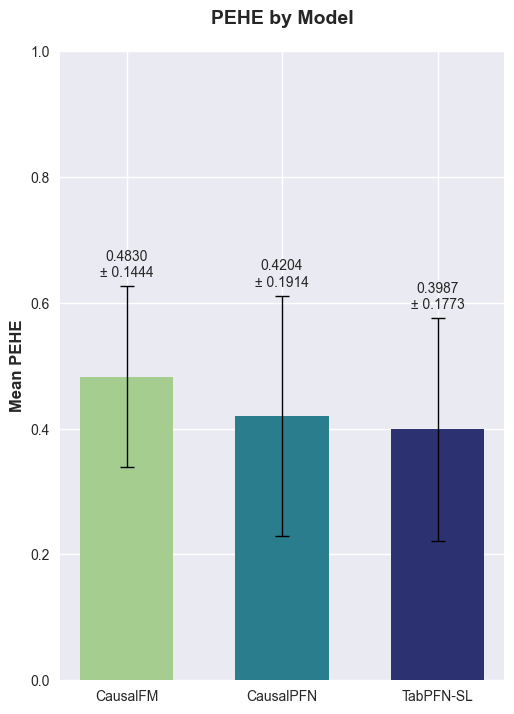

In [ ]:
stats = df.groupby('model')['pehe'].agg(['mean', 'std']).reset_index()

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(5, 7))


cmap = sns.color_palette("crest", as_cmap=True)
bars = ax.bar(
    range(len(stats)),
    stats['mean'],
    yerr=stats['std'],
    capsize=5,
    error_kw={'linewidth': 1, 'capthick': 1, 'color': 'black'},
    width=0.6,
    color=[cmap(i/.9) for i in np.linspace(0, 1, len(stats))],
    # edgecolor='black',
    linewidth=1,
)

# Customize plot
ax.set_ylabel('Mean PEHE', fontsize=12, fontweight='bold')
ax.set_title('PEHE by Model',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(stats)))
ax.set_xticklabels(stats['model'])
ax.set_ylim(0, 1)

# Add value labels on bars
for i, (idx, row) in enumerate(stats.iterrows()):
    ax.text(i, row['mean'] + row['std'] + 0.01,
            f"{row['mean']:.4f}\n± {row['std']:.4f}",
            ha='center', va='bottom', fontsize=10)

plt.tight_layout(pad=.2)
plt.show()

# Reset style to default
plt.style.use('default')